In [2]:
from google.colab import files
files.upload()  # This will open a file upload dialog

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gillanisyed","key":"e69dfd41e2085231267d7351de5c4378"}'}

In [3]:
# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Plant Disease dataset
!kaggle datasets download -d emmarex/plantdisease

# Unzip the dataset
!unzip -q plantdisease.zip -d plantdisease


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 97% 638M/658M [00:03<00:00, 60.6MB/s]
100% 658M/658M [00:03<00:00, 187MB/s] 


In [4]:
!find plantdisease -maxdepth 2 -type d

plantdisease
plantdisease/PlantVillage
plantdisease/PlantVillage/Tomato_Septoria_leaf_spot
plantdisease/PlantVillage/Tomato_Late_blight
plantdisease/PlantVillage/Tomato_healthy
plantdisease/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite
plantdisease/PlantVillage/Pepper__bell___healthy
plantdisease/PlantVillage/Pepper__bell___Bacterial_spot
plantdisease/PlantVillage/Tomato_Early_blight
plantdisease/PlantVillage/Tomato_Bacterial_spot
plantdisease/PlantVillage/Tomato_Leaf_Mold
plantdisease/PlantVillage/Potato___Late_blight
plantdisease/PlantVillage/Potato___healthy
plantdisease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
plantdisease/PlantVillage/Tomato__Tomato_mosaic_virus
plantdisease/PlantVillage/Tomato__Target_Spot
plantdisease/PlantVillage/Potato___Early_blight
plantdisease/plantvillage
plantdisease/plantvillage/PlantVillage


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Apply data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image values to [0, 1]
    shear_range=0.2,  # Apply random shearing
    zoom_range=0.2,   # Apply random zooming
    horizontal_flip=True,  # Apply random horizontal flipping
    rotation_range=40,  # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20%
    height_shift_range=0.2,  # Shift images vertically by up to 20%
    brightness_range=[0.2, 1.8],  # Randomly adjust brightness
    validation_split=0.2  # 20% of data will be used for validation
)


# For validation data, we only rescale (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Set up the directory path
train_dir = 'plantdisease/PlantVillage'  # Adjust path if necessary

# Create generators for the training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize all images to 150x150
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use this subset for training data
)

validation_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use this subset for validation data
)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [28]:
from tensorflow.keras import layers, models

# Build the CNN model with an Input layer
model = models.Sequential([
    layers.InputLayer(input_shape=(150, 150, 3)),  # Define input shape
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')  # Number of output classes (diseases)
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,041,359 (72.64 MB)

 Trainable params: 19,041,359 (72.64 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
EPOCHS = 10  # You can change the number of epochs if needed

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 123s 232ms/step - accuracy: 0.3382 - loss: 2.0805 - val_accuracy: 0.6373 - val_loss: 1.1435
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 117s 227ms/step - accuracy: 0.6656 - loss: 1.0175 - val_accuracy: 0.6390 - val_loss: 1.3081
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 117s 226ms/step - accuracy: 0.7323 - loss: 0.7876 - val_accuracy: 0.6776 - val_loss: 1.2088
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 116s 225ms/step - accuracy: 0.7911 - loss: 0.6181 - val_accuracy: 0.8399 - val_loss: 0.4624
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 116s 224ms/step - accuracy: 0.8152 - loss: 0.5476 - val_accuracy: 0.8173 - val_loss: 0.5712
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 115s 223ms/step - accuracy: 0.8421 - loss: 0.4749 - val_accuracy: 0.8023 - val_loss: 0.7347
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 114s 221ms/step - accuracy: 0.8451 - loss: 0.4556 - val_accuracy: 0.8826 - val_loss: 0.3747
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 115s 223ms/step - accuracy: 0.8716 -

In [30]:
# Save the model in the newer Keras format
model.save('plant_disease_model.keras')


In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Initialize the lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop through the validation data to predict and compare
for batch_idx in range(validation_generator.samples // validation_generator.batch_size):
    # Get a batch of validation data
    img_batch, labels_batch = next(validation_generator)  # Use next() instead of next()

    # Predict the class for each image in the batch
    predictions = model.predict(img_batch)

    # Get the predicted class index (class with highest probability)
    predicted_class_indices = np.argmax(predictions, axis=1)

    # Get the true class indices
    true_class_indices = np.argmax(labels_batch, axis=1)

    # Append the true and predicted labels to the lists
    true_labels.extend(true_class_indices)
    predicted_labels.extend(predicted_class_indices)

# Convert the true and predicted labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix (this will show how many times each class was misclassified)
print("Confusion Matrix:")
print(conf_matrix)

# Identify which class the model got wrong the most
misclassified = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)  # Number of misclassified samples per class
most_misclassified_class = np.argmax(misclassified)
print(f"The most misclassified class is: {list(train_generator.class_indices.keys())[most_misclassified_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━

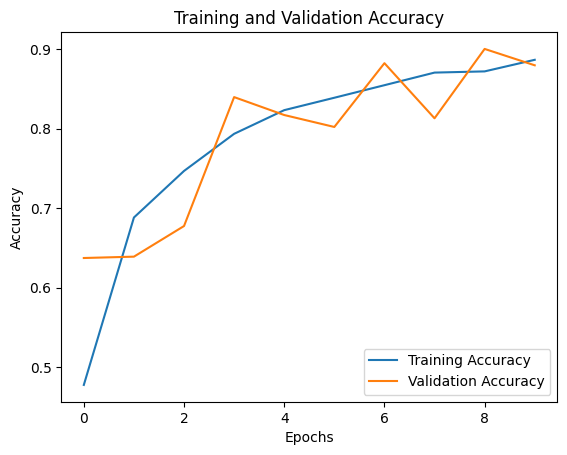

In [32]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


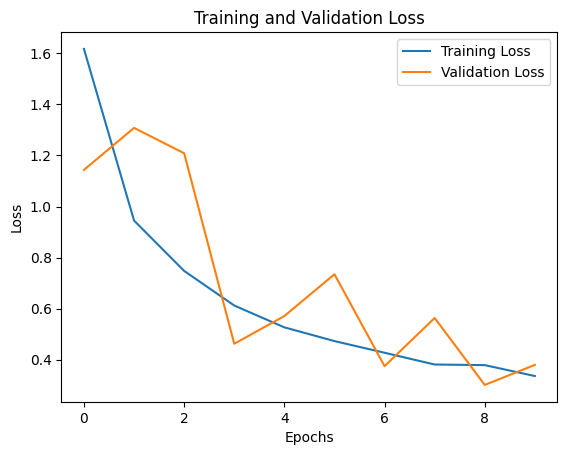

In [33]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [34]:
# Evaluate on validation data
test_loss, test_acc = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")


128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8780 - loss: 0.3858
Test accuracy: 0.880126953125
Test loss: 0.3792889416217804


In [36]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

# Step 1: Define the folder path containing your images
folder_path = '/content/testdata'  # Replace with the path to your folder

# Step 2: Loop through each image in the folder
for img_name in os.listdir(folder_path):
    # Check if the file is an image (you can add more extensions if needed)
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Construct the full image path
        img_path = os.path.join(folder_path, img_name)

        # Step 3: Load the image and resize it to the model's input size
        img = image.load_img(img_path, target_size=(150, 150))

        # Step 4: Preprocess the image (convert to numpy array, add batch dimension, normalize)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize the image

        # Step 5: Make the prediction using the trained model
        predictions = model.predict(img_array)

        # Step 6: Get the predicted class index (the class with the highest probability)
        predicted_class_index = np.argmax(predictions, axis=1)

        # Step 7: Map the predicted index to the actual class name (from train_generator's class_indices)
        class_labels = train_generator.class_indices  # Mapping of class indices to class names
        class_labels = {v: k for k, v in class_labels.items()}  # Reverse the dictionary

        # Get the predicted class name
        predicted_class_name = class_labels[predicted_class_index[0]]

        # Step 8: Print the result
        print(f"Image: {img_name} - Predicted class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image: pepper_bell_healthy.jpg - Predicted class: Pepper__bell___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image: tomato_leaf_mold.jpg - Predicted class: Tomato_Leaf_Mold
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image: tomato_early_blight.jpg - Predicted class: Tomato_Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: tomato_bacterial_spot.jpg - Predicted class: Tomato_Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: tomato_septoria_leaf.jpg - Predicted class: Tomato_Septoria_leaf_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: tomato_spider_mites1.jpg - Predicted class: Tomato_Spider_mites_Two_spotted_spider_mite
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image: tomato_healthy.jpg - Predicted class: Tomato_healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: pepper_bell_bacteria1.jpg - Predicted class: Pepper__bell___Bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image: tomato_septoria_leaf1.jpg - Predicted class: Tomato_Septor